# MSAS Knee<=600: Model Comparison (Ridge / XGBoost / RandomForest)

This notebook compares three models for the binary label `knee_before_600`.
We report Accuracy, ROC AUC, PR AUC, RMSE, and MAE, plus class-balance context.

Label definition:
- `knee_before_600 = 1` if the detected knee EFC <= 600
- If no knee is detected but the cell has enough coverage (max EFC >= 600), we label it as `0`
- If max EFC < 600 and no knee is detected, label is NaN and the cell is dropped

Interpretation tips:
- Prefer PR AUC over Accuracy when positives are rare
- Compare Accuracy against the majority-class baseline

Prereqs:
- `data/processed/MSAS` exists (run MSAS preprocessing first).
- `batteryml` is importable.
- `xgboost` is installed for the XGBoost model.


In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

import batteryml
from batteryml.pipeline import Pipeline

In [2]:
try:
    import xgboost  # noqa: F401
except ImportError as exc:
    raise ImportError("xgboost is required for the XGBoost model. Install it first.") from exc

In [3]:
def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "batteryml").exists() and (p / "configs").exists():
            return p
    return start

env_root = os.environ.get("BATTERYML_REPO_ROOT")
if env_root:
    repo_root = Path(env_root)
else:
    repo_root = find_repo_root(Path.cwd())
    if not (repo_root / "configs").exists():
        pkg_root = Path(batteryml.__file__).resolve().parents[1]
        repo_root = find_repo_root(pkg_root)

os.chdir(repo_root)
data_root = repo_root / "data/processed/MSAS"
if not data_root.exists():
    raise FileNotFoundError(
        f"MSAS processed data not found: {data_root}. Run preprocessing first."
    )

config_map = {
    "Ridge": "configs/soh/transfer/msas_knee_before_600_efcnorm_ridge.yaml",
    "XGBoost": "configs/soh/transfer/msas_knee_before_600_efcnorm_xgb.yaml",
    "RandomForest": "configs/soh/transfer/msas_knee_before_600_efcnorm_rf.yaml",
}

force_rerun = True  # set False to reuse existing checkpoints
results = []
curve_data = {}

for name, rel_path in config_map.items():
    config_path = repo_root / rel_path
    if not config_path.exists():
        raise FileNotFoundError(f"Missing config: {config_path}")
    workspace = repo_root / f"workspaces/msas/knee_before_600_compare/{name.lower()}"
    pipe = Pipeline(config_path=str(config_path), workspace=str(workspace))
    model, dataset = pipe.train(skip_if_executed=not force_rerun)
    prediction = model.predict(dataset)

    y_true = dataset.test_data.label.detach().cpu().numpy().reshape(-1)
    y_pred = prediction.detach().cpu().numpy().reshape(-1)
    y_hat = (y_pred >= 0.5).astype(int)

    accuracy = float((y_hat == y_true).mean())
    pos = int((y_true == 1).sum())
    neg = int((y_true == 0).sum())
    n = int(len(y_true))
    pos_rate = float(pos / n) if n else float('nan')
    majority_acc = float(max(pos, neg) / n) if n else float('nan')
    rmse = dataset.evaluate(prediction, "RMSE")
    mae = dataset.evaluate(prediction, "MAE")

    if len(np.unique(y_true)) < 2:
        roc_auc = float("nan")
        pr_auc = float("nan")
    else:
        roc_auc = float(roc_auc_score(y_true, y_pred))
        pr_auc = float(average_precision_score(y_true, y_pred))
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        prec, rec, _ = precision_recall_curve(y_true, y_pred)
        curve_data[name] = {"fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec}

    results.append({
        "model": name,
        "n_test": n,
        "pos_test": pos,
        "neg_test": neg,
        "pos_rate": pos_rate,
        "majority_acc": majority_acc,
        "accuracy": accuracy,
        "ROC_AUC": roc_auc,
        "PR_AUC": pr_auc,
        "RMSE": rmse,
        "MAE": mae,
    })

results_df = pd.DataFrame(results).sort_values("accuracy", ascending=False).reset_index(drop=True)
results_df

c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\knee_before_600_compare\ridge
Seed is set to 0.
Load datasets from cache cache\battery_cache_91e1e09acd92a553b45c747b39695e6e.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\knee_before_600_compare\xgboost
Seed is set to 0.
Load datasets from cache cache\battery_cache_91e1e09acd92a553b45c747b39695e6e.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\knee_before_600_compare\randomforest
Seed is set to 0.
Load datasets from cache cache\battery_cache_91e1e09acd92a553b45c747b39695e6e.pkl.


,model,n_test,pos_test,neg_test,pos_rate,majority_acc,accuracy,ROC_AUC,PR_AUC,RMSE,MAE
0,Ridge,30,5,25,0.166667,0.833333,0.9,0.984,0.926667,0.245001,0.187757
1,XGBoost,30,5,25,0.166667,0.833333,0.9,1.000,1.000000,0.258794,0.099467
2,RandomForest,30,5,25,0.166667,0.833333,0.9,0.976,0.925000,0.258755,0.118600


In [4]:
# Quick read: is accuracy above majority baseline?
display(results_df[["model", "n_test", "pos_test", "neg_test", "pos_rate", "majority_acc", "accuracy", "ROC_AUC", "PR_AUC"]])

for _, r in results_df.iterrows():
    if np.isfinite(r['majority_acc']) and r['accuracy'] <= r['majority_acc'] + 1e-12:
        print(f"WARNING: {r['model']} accuracy ({r['accuracy']:.3f}) does not beat majority baseline ({r['majority_acc']:.3f}).")

,model,n_test,pos_test,neg_test,pos_rate,majority_acc,accuracy,ROC_AUC,PR_AUC
0,Ridge,30,5,25,0.166667,0.833333,0.9,0.984,0.926667
1,XGBoost,30,5,25,0.166667,0.833333,0.9,1.000,1.000000
2,RandomForest,30,5,25,0.166667,0.833333,0.9,0.976,0.925000


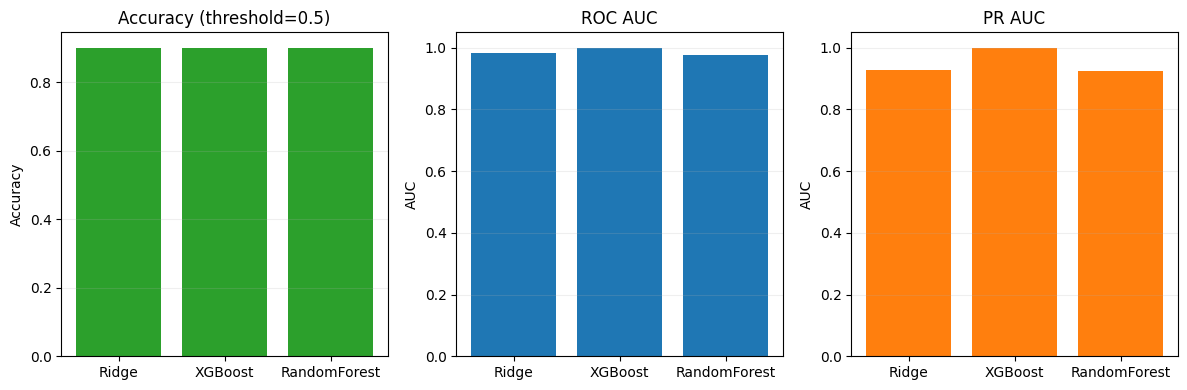

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].bar(results_df["model"], results_df["accuracy"], color="#2ca02c")
axes[0].set_title("Accuracy (threshold=0.5)")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, axis="y", alpha=0.2)

axes[1].bar(results_df["model"], results_df["ROC_AUC"], color="#1f77b4")
axes[1].set_title("ROC AUC")
axes[1].set_ylabel("AUC")
axes[1].grid(True, axis="y", alpha=0.2)

axes[2].bar(results_df["model"], results_df["PR_AUC"], color="#ff7f0e")
axes[2].set_title("PR AUC")
axes[2].set_ylabel("AUC")
axes[2].grid(True, axis="y", alpha=0.2)

plt.tight_layout()

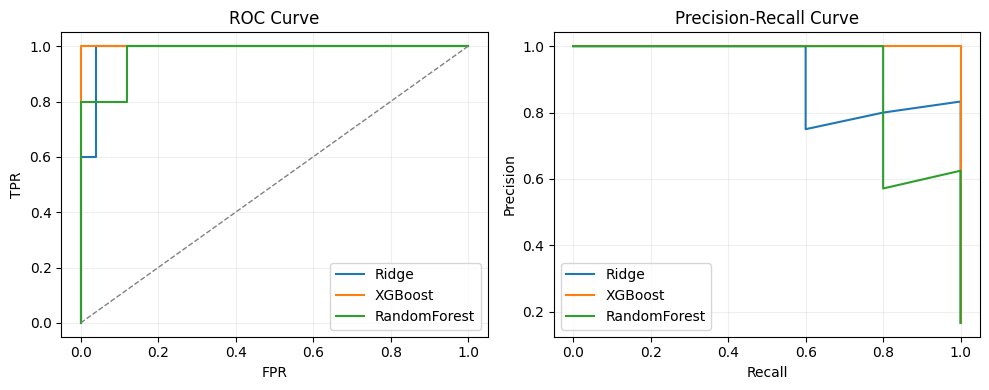

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for name, curves in curve_data.items():
    axes[0].plot(curves["fpr"], curves["tpr"], label=name)
    axes[1].plot(curves["rec"], curves["prec"], label=name)

axes[0].plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1)
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].grid(True, alpha=0.2)

axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].grid(True, alpha=0.2)

for ax in axes:
    ax.legend()

plt.tight_layout()

## Sanity Checks
These checks help validate whether very high AUC/PR results are credible:
- class balance in train/test
- how far the feature checkpoints (100/200/300 EFC) are actually matched (given `max_abs_efc_error`)
- whether the selected checkpoint curves are still truly "early"

### How cells with no knee are handled
Configured behavior for this notebook/configs: if `KneeBeforeEFCLabelAnnotator` cannot detect a knee, but the cell has enough coverage (max EFC >= threshold), we label it as **0** (knee is not before threshold).

If knee cannot be detected and max EFC < threshold, the label remains NaN and BatteryML's `Task.build()` drops the cell from train/test (treated as unknown).

In [7]:
from batteryml.pipeline import load_config, build_dataset
from batteryml.feature import efc_normalized_voltage_capacity_matrix as efc_feat

# Use Ridge config for dataset-level sanity checks (dataset is identical across models).
sanity_config_path = repo_root / config_map["Ridge"]
sanity_workspace = repo_root / "workspaces/msas/_sanity_knee_before_600"

cfg = load_config(str(sanity_config_path), str(sanity_workspace))
dataset_sanity, raw_data = build_dataset(cfg, device="cpu")
train_cells = raw_data["train_cells"]
test_cells = raw_data["test_cells"]

y_train = dataset_sanity.train_data.label.detach().cpu().numpy().reshape(-1)
y_test = dataset_sanity.test_data.label.detach().cpu().numpy().reshape(-1)

def summarize_balance(name, y):
    pos = int(np.sum(y == 1))
    neg = int(np.sum(y == 0))
    n = len(y)
    rate = float(pos / n) if n else float('nan')
    maj_acc = float(max(pos, neg) / n) if n else float('nan')
    print(f"{name}: n={n}, pos={pos}, neg={neg}, pos_rate={rate:.3f}, majority_accuracy={maj_acc:.3f}")

summarize_balance('train', y_train)
summarize_balance('test', y_test)

c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\_sanity_knee_before_600
Load datasets from cache cache\battery_cache_91e1e09acd92a553b45c747b39695e6e.pkl.
train: n=109, pos=15, neg=94, pos_rate=0.138, majority_accuracy=0.862
test: n=30, pos=5, neg=25, pos_rate=0.167, majority_accuracy=0.833


In [8]:
# Check how far checkpoint matching drifts from targets
feat_cfg = cfg["feature"]
checkpoints = feat_cfg.get("efc_checkpoints", [100.0, 200.0, 300.0])
max_abs_efc_error = float(feat_cfg.get("max_abs_efc_error", 10.0))
allowed_tags = feat_cfg.get("allowed_tags")
allowed_tag_set = set(str(x) for x in allowed_tags) if allowed_tags else None

def selected_meta(cell, target):
    cycles = list(cell.cycle_data or [])
    c = efc_feat._pick_cycle_by_efc(
        cycles,
        float(target),
        max_abs_error=max_abs_efc_error,
        allowed_tags=allowed_tag_set,
    )
    if c is None:
        return None
    meta = getattr(c, 'additional_data', {}) or {}
    return {
        'msas_efc': meta.get('msas_efc'),
        'msas_tag': meta.get('msas_tag'),
    }

rows = []
for cell in test_cells:
    for cp in checkpoints:
        meta = selected_meta(cell, cp)
        if meta is None or meta['msas_efc'] is None:
            rows.append({'cell_id': cell.cell_id, 'checkpoint': float(cp), 'selected_efc': np.nan, 'selected_tag': None})
            continue
        rows.append({
            'cell_id': cell.cell_id,
            'checkpoint': float(cp),
            'selected_efc': float(meta['msas_efc']),
            'selected_tag': str(meta['msas_tag']) if meta['msas_tag'] is not None else None,
        })

sel = pd.DataFrame(rows)
sel['abs_err'] = (sel['selected_efc'] - sel['checkpoint']).abs()

print('max_abs_efc_error:', max_abs_efc_error)
display(sel.groupby('checkpoint').agg(
    n=('selected_efc', 'size'),
    missing=('selected_efc', lambda s: int(s.isna().sum())),
    abs_err_p50=('abs_err', lambda s: float(np.nanpercentile(s, 50))),
    abs_err_p90=('abs_err', lambda s: float(np.nanpercentile(s, 90))),
    selected_efc_p50=('selected_efc', lambda s: float(np.nanpercentile(s, 50))),
    selected_efc_p90=('selected_efc', lambda s: float(np.nanpercentile(s, 90))),
))

# How often checkpoints drift beyond what we'd consider 'early'?
for cp in checkpoints:
    s = sel[sel['checkpoint'] == float(cp)]['selected_efc']
    s = s.dropna()
    if len(s) == 0:
        continue
    frac_gt_300 = float((s > 300).mean())
    frac_gt_600 = float((s > 600).mean())
    print(f"checkpoint {float(cp):.0f}: frac(selected_efc>300)={frac_gt_300:.2%}, frac(selected_efc>600)={frac_gt_600:.2%}")

# Show a few examples with large drift
sel_sorted = sel.sort_values(['checkpoint', 'abs_err'], ascending=[True, False])
display(sel_sorted.head(15))

max_abs_efc_error: 400.0


,n,missing,abs_err_p50,abs_err_p90,selected_efc_p50,selected_efc_p90
checkpoint,,,,,,
100.0,30,0,11.372190,24.125099,107.667991,124.125099
200.0,30,0,17.599922,39.110285,187.415435,217.344941
300.0,30,0,14.477295,39.772117,302.907430,323.248795


checkpoint 100: frac(selected_efc>300)=0.00%, frac(selected_efc>600)=0.00%
checkpoint 200: frac(selected_efc>300)=0.00%, frac(selected_efc>600)=0.00%
checkpoint 300: frac(selected_efc>300)=60.00%, frac(selected_efc>600)=0.00%


,cell_id,checkpoint,selected_efc,selected_tag,abs_err
57,MSAS_S2_TP_z11_02,100.0,125.441021,CU,25.441021
0,MSAS_S2_TP_z11_03,100.0,125.372170,CU,25.372170
27,MSAS_S1_TP_z22_03,100.0,124.450084,CU,24.450084
36,MSAS_S1_TP_z22_02,100.0,124.088990,CU,24.088990
51,MSAS_S2_TP_z08_01,100.0,121.465608,CU,21.465608
39,MSAS_S1_TP_z06_03,100.0,117.184701,CU,17.184701
72,MSAS_S2_TP_z18_03,100.0,117.023889,CU,17.023889
60,MSAS_S2_TP_z22_01,100.0,116.963409,CU,16.963409
78,MSAS_S1_TP_z06_01,100.0,116.850492,CU,16.850492
21,MSAS_S2_TP_z24_02,100.0,116.670584,CU,16.670584
